In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
# Importing various modules for data visualisation and manipulation
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import style
import seaborn as sns
import glob
import collections
import networkx as nx
import gc
from collections import Counter

In [4]:
# Import the necessary modelling algorithms
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import tree, metrics 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.ensemble import BaggingClassifier 
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import SGDClassifier 

from sklearn.metrics import roc_curve,accuracy_score,precision_score,recall_score,roc_auc_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict,cross_val_score,cross_validate,StratifiedKFold

from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier

## data input

In [5]:
final_df = pd.read_csv('./vif.csv')
#del vif_df['Unnamed: 0']
# df = df.set_index('id')
final_df = final_df.set_index('id')
final_df

,user_id,merchant_id,label,recency,repur_mers,cart_r,buy_r,ncart,nbuy,nfav,...,i_min,c_size,c_mean,c_min,b_size,m_cart_r_y,time_range_y,ts_count,umi_min,umc_size
id,,,,,,,,,,,,,,,,,,,,,
34176_3906,34176,3906,0,4,1.0,0.0,0.075388,0.0,14.0,0.0,...,1,20,813.450000,5,1,0.0,21,9,1,6
34176_121,34176,121,0,4,1.0,0.0,0.075388,0.0,14.0,0.0,...,1,26,3071.730769,1,1,0.0,3,3,14,1
34176_4356,34176,4356,1,4,1.0,0.0,0.075388,0.0,14.0,0.0,...,1,15,484.600000,1,1,0.0,1,2,1,1
34176_2217,34176,2217,0,4,1.0,0.0,0.075388,0.0,14.0,0.0,...,1,5,12040.400000,614,1,0.0,0,1,2,1
230784_4818,230784,4818,0,27,0.0,0.0,0.129630,0.0,5.0,0.0,...,1,27,1781.074074,2,1,0.0,3,3,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359807_4325,359807,4325,0,8,0.0,0.0,0.076923,0.0,2.0,0.0,...,1,18,1099.388889,7,1,0.0,0,1,1,2
294527_3971,294527,3971,0,47,0.0,0.0,0.025253,0.0,1.0,1.0,...,1,7,4127.428571,4,1,0.0,2,2,4,1
294527_152,294527,152,0,47,0.0,0.0,0.025253,0.0,1.0,1.0,...,1,13,623.615385,1,1,0.0,0,1,9,1


In [6]:
X0 = final_df.drop(['user_id','merchant_id','label'],axis = 1)
Y0 = final_df['label'].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X0, Y0, test_size=0.3, random_state = 42,stratify = Y0)

## class balance

In [7]:
final_df['label'].value_counts()

0    244912
1     15952
Name: label, dtype: int64

In [8]:
class_balance = final_df['label'].value_counts()[1]/final_df['label'].value_counts().sum()
print('Class Balance = ',class_balance)

Class Balance =  0.06115063788027478


## Select and Train Models

In [9]:
model_dict = {'Logistic Regression':LogisticRegression(),
              'Random Forrest':RandomForestClassifier(),
              'Decision Tree Classifier':tree.DecisionTreeClassifier(),
              'ExtraTrees Classifier':ExtraTreesClassifier(),
              'KNeighbors Classifier':KNeighborsClassifier(),
              'AdaBoost Classifier':AdaBoostClassifier(),
              'Bagging Classifier':BaggingClassifier(),
              'GradientBoosting Classifier':GradientBoostingClassifier(),
              'Support Vector Machines':SVC(),
              'Stochastic Gradient Descent':SGDClassifier(),
              'XGBoost':XGBClassifier(),
              'GaussianNB':GaussianNB(),
             }

In [10]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = 3
list_models_scores = list()

for model_name, model in model_dict.items():
    cv_score = cross_validate(model,Xtrain,ytrain, cv=folds, return_train_score=False, n_jobs=-1) 
    ypred = cross_val_predict(model, Xtrain, ytrain, cv=folds)
    list_models_scores.append({'Model': model_name,
                                     'Train Accuracy':accuracy_score(ytrain,ypred),
                                     'Precision':precision_score(ytrain,ypred), 
                                     'Recall': recall_score(ytrain,ypred),
                                     'F1-Measure': f1_score(ytrain,ypred),
                                     'fitting_time': cv_score['fit_time'].mean()
                                    })
    


#result
pd.DataFrame(list_models_scores)

[13:50:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:50:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:50:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

,Model,Train Accuracy,Precision,Recall,F1-Measure,fitting_time
0,Logistic Regression,0.938353,0.111111,0.001164,0.002304,1.528090
1,Random Forrest,0.974300,0.725336,0.933011,0.816170,13.948209
2,Decision Tree Classifier,0.966529,0.730230,0.717804,0.723964,0.426977
3,ExtraTrees Classifier,0.973900,0.722841,0.929608,0.813288,9.538768
4,KNeighbors Classifier,0.936053,0.169470,0.011732,0.021945,0.090949
5,AdaBoost Classifier,0.974447,0.725600,0.936145,0.817535,8.941982
6,Bagging Classifier,0.970203,0.738920,0.792853,0.764937,2.524077
7,GradientBoosting Classifier,0.974962,0.714620,0.983163,0.827654,36.378134
8,Support Vector Machines,0.938851,0.000000,0.000000,0.000000,241.341012
9,Stochastic Gradient Descent,0.921201,0.179303,0.080691,0.111296,6.285874


# Resample

In [11]:
df_sampling = final_df.copy()
print('Current DataFrame:')
print(df_sampling.label.value_counts())

df_majority = df_sampling[df_sampling.label==0]
df_minority = df_sampling[df_sampling.label==1]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples= df_sampling[df_sampling.label==1].shape[0],    
                                 random_state=1) 

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

clean_dataset_dropped = df_downsampled.copy()    

#result
print('Data Frame following Downsampling:')
print(df_downsampled.label.value_counts())

Current DataFrame:
0    244912
1     15952
Name: label, dtype: int64
Data Frame following Downsampling:
0    15952
1    15952
Name: label, dtype: int64


In [12]:
X = df_downsampled.drop(['user_id','merchant_id','label'],axis = 1)
Y = df_downsampled['label'].values
Xtrain, Xtest1, ytrain, ytest1 = train_test_split(X, Y, test_size=0.2, random_state = 42, stratify= Y)

In [13]:
# folds = StratifiedKFold(n_splits=5, shuffle=True) #, random_state=42)
# folds = 3
list_models_scores = list()

for model_name, model in model_dict.items():
    cv_score = cross_validate(model,Xtrain,ytrain, cv=folds, return_train_score=False, n_jobs=-1) #scoring = scoring
    ypred = cross_val_predict(model, Xtrain, ytrain, cv=folds)
    list_models_scores.append({'Model': model_name,
                                     'Train Accuracy':accuracy_score(ytrain,ypred),
                                     'Precision':precision_score(ytrain,ypred), 
                                     'Recall': recall_score(ytrain,ypred),
                                     'F1-Measure': f1_score(ytrain,ypred),
                                     'fitting_time': cv_score['fit_time'].mean()
                                    })

# result
pd.DataFrame(list_models_scores)

[13:53:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

,Model,Train Accuracy,Precision,Recall,F1-Measure,fitting_time
0,Logistic Regression,0.606512,0.593110,0.678577,0.632972,0.266451
1,Random Forrest,0.986561,0.973827,1.000000,0.986740,2.277339
2,Decision Tree Classifier,0.966618,0.973370,0.959489,0.966380,0.141006
3,ExtraTrees Classifier,0.986483,0.973823,0.999843,0.986662,1.407436
4,KNeighbors Classifier,0.566861,0.568209,0.557123,0.562611,0.014595
5,AdaBoost Classifier,0.986561,0.973827,1.000000,0.986740,1.065176
6,Bagging Classifier,0.985464,0.973771,0.997806,0.985642,0.868152
7,GradientBoosting Classifier,0.986169,0.973807,0.999216,0.986348,4.172773
8,Support Vector Machines,0.529836,0.548846,0.335449,0.416399,28.000375
9,Stochastic Gradient Descent,0.547271,0.541220,0.620906,0.578331,0.285269


# Fine-Tune

In [14]:
def model_fit_ensemble(model, param_grid, folds):
    model_gs = GridSearchCV(model, param_grid, cv=folds)
    model_gs.fit(Xtrain, ytrain)
    model_best = model_gs.best_estimator_
    print(model_gs.best_estimator_)
    ypred = cross_val_predict(model_best, Xtrain, ytrain, cv=folds)
    model_accuracy = accuracy_score(ytrain,ypred) 
    model_precision = precision_score(ytrain,ypred)
    model_recall = recall_score(ytrain,ypred)
    model_f1 = f1_score(ytrain,ypred)
    print('Train Accuracy:',model_accuracy,
          'Precision:',model_precision,
          'Recall:', model_recall,
          'F1 Score:', model_f1)
    
    return model_best

In [15]:
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

param_grid_RFC = [{'n_estimators':[200,350,500],'max_features':['auto',5],'max_depth':[100,200],'random_state':[42]}]
param_grid_xgb = [{'n_estimators':[200,350,500],'max_depth':[5,7],'random_state':[42],'objective':['binary:logitraw']}]
param_grid_bagging = [{'random_state':[42],'max_features':[10,20,30]}]

rfc_best = model_fit_ensemble(RandomForestClassifier(), param_grid_RFC, folds)
xgb_best = model_fit_ensemble(XGBClassifier(), param_grid_xgb, folds)
bagging_best = model_fit_ensemble(BaggingClassifier(), param_grid_bagging, folds)



RandomForestClassifier(max_depth=100, n_estimators=200, random_state=42)
Train Accuracy: 0.9865611409317087 Precision: 0.9738267836703548 Recall: 1.0 F1 Score: 0.9867398615997217
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1,
              objective='binary:logitraw', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Train Accuracy: 0.9857383536418133 Precision: 0.9741471623068686 Recall: 0.9979627017708823 F1 Score: 0.9859111317541415
BaggingClassifier(max_features=20, random_state=42)
Train Accuracy: 0.9858

In [16]:
rfc_best = RandomForestClassifier(max_depth=100, n_estimators=200, random_state=42)

xgb_best = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1,
              objective='binary:logitraw', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

bagging_best = BaggingClassifier(max_features=30, random_state=42)

## Feature Importances

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1,
              objective='binary:logitraw', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

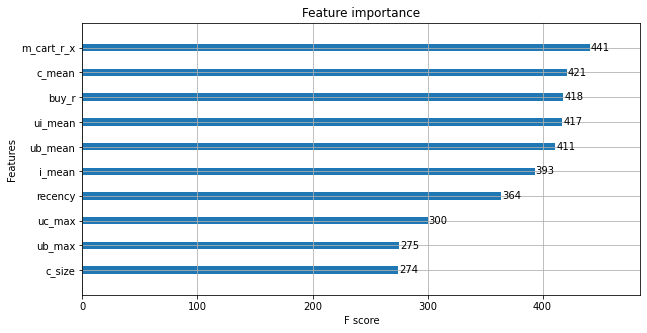

In [17]:
xgb_best.fit(Xtrain, ytrain)
fig, ax = plt.subplots(figsize = (10,5))
plot_importance(xgb_best, height = 0.3, ax = ax, max_num_features = 10)
# importance_type = 'weight'
plt.show()

RandomForestClassifier(max_depth=100, n_estimators=200, random_state=42)

<AxesSubplot:xlabel='feature'>

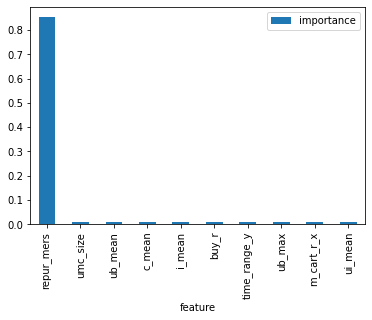

In [18]:
rfc_best.fit(Xtrain, ytrain)
rfc_features = pd.DataFrame(Xtrain.columns, columns = ['feature'])
rfc_features['importance'] = rfc_best.feature_importances_
rfc_features_df = rfc_features.sort_values(by = 'importance', ascending = False).head(10)
rfc_features_df.plot(x = 'feature',kind = 'bar')

## Soft Voting

In [19]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
voting_clf_param =[('RF', rfc_best),('XGB', xgb_best),('BAG', bagging_best)]
vote_best = VotingClassifier(estimators=voting_clf_param, voting='soft',flatten_transform=False)
vote_best.fit(Xtrain, ytrain)

ypred = cross_val_predict(vote_best, Xtrain, ytrain, cv=folds)
vote_accuracy = accuracy_score(ytrain,ypred)
vote_precision = precision_score(ytrain,ypred)
vote_recall = recall_score(ytrain,ypred)
vote_f1 = f1_score(ytrain,ypred)
print('Train Accuracy:',vote_accuracy,
                     'Precision:',vote_precision,
                     'Recall:',vote_recall,
                     'F1:', vote_f1)

#Train Accuracy: 0.8103067484662577 
# Precision: 0.8242245199409158 
#Recall: 0.8009569377990431 
#F1: 0.812424168891046

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(max_depth=100,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=7,
                                            min_child_weight=1, missing=nan,
                                            monotone_constrain

Train Accuracy: 0.9861301571131921 Precision: 0.9739495798319328 Recall: 0.9989813508854412 F1: 0.9863066687296921


In [20]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
voting_clf_param =[('RF', rfc_best),('XGB', xgb_best),('BAG', bagging_best)]
vote_best_test = VotingClassifier(estimators=voting_clf_param, voting='soft',flatten_transform=False)
vote_best_test.fit(Xtrain, ytrain)
ypred = vote_best_test.predict(Xtest1)
#ypred = cross_val_predict(vote_best, Xtrain, ytrain, cv=folds)

vote_accuracy = accuracy_score(ytest1,ypred)
vote_precision = precision_score(ytest1,ypred)
vote_recall = recall_score(ytest1,ypred)
vote_f1 = f1_score(ytest1,ypred)

print('Train Accuracy:',vote_accuracy,
                     'Precision:',vote_precision,
                     'Recall:',vote_recall,
                     'F1:', vote_f1)

#Train Accuracy: 0.8103067484662577 
# Precision: 0.8242245199409158 
#Recall: 0.8009569377990431 
#F1: 0.812424168891046

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(max_depth=100,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=7,
                                            min_child_weight=1, missing=nan,
                                            monotone_constrain

Train Accuracy: 0.9871493496317192 Precision: 0.9749388753056235 Recall: 1.0 F1: 0.9873104302073662


In [21]:
ypred = vote_best_test.predict(Xtest)
#cross_val_predict(vote_best,Xtest1, ytest1, cv=folds)

vote_accuracy = accuracy_score(ytest,ypred)
vote_precision = precision_score(ytest,ypred)
vote_recall = recall_score(ytest,ypred)
vote_f1 = f1_score(ytest,ypred)

print('Train Accuracy:',vote_accuracy,
                     'Precision:',vote_precision,
                     'Recall:',vote_recall,
                     'F1:', vote_f1)

#Train Accuracy: 0.8103067484662577 
# Precision: 0.8242245199409158 
#Recall: 0.8009569377990431 
#F1: 0.812424168891046

Train Accuracy: 0.9750702785586507 Precision: 0.710405224877542 Recall: 1.0 F1: 0.8306864531805953


<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 15.0, 'Predicted')

Text(33.0, 0.5, 'Actual')

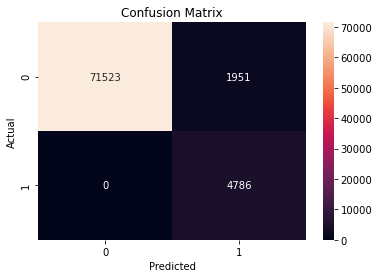

In [22]:
# Confusion Matrix
confusion = metrics.confusion_matrix(ytest, vote_best_test.predict(Xtest))

# [row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

# Plot Confusion Matrix
sns.heatmap(confusion, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 15.0, 'Predicted')

Text(33.0, 0.5, 'Actual')

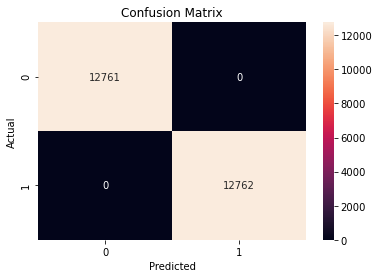

In [23]:
# Confusion Matrix
confusion = metrics.confusion_matrix(ytrain, vote_best_test.predict(Xtrain))

# [row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

# Plot Confusion Matrix
sns.heatmap(confusion, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## ROC Curve

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label, color='#295D7F')
    plt.plot([0, 1], [0, 1], 'k--', color='grey')
    
    plt.axis([-0.01, 1.05, -0.01, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, color='#383838')
    plt.ylabel('True Positive Rate', fontsize=12, color='#383838')


<Figure size 576x288 with 0 Axes>

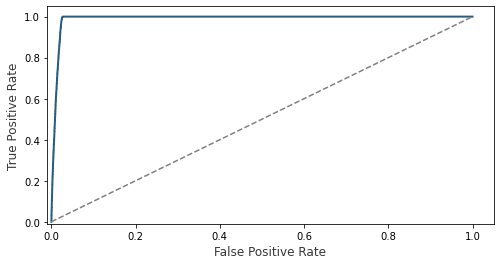

In [25]:
#calculate prediction probability
y_pred_proba = vote_best_test.predict_proba(Xtest)[::,1]
#set true and false predictions
fpr, tpr, _ = roc_curve(ytest, y_pred_proba)

#plot actual graph
plt.figure(figsize=(8, 4))
plot_roc_curve(fpr, tpr)
plt.show()

## Learning Curve

In [26]:
from sklearn.model_selection import learning_curve 
import numpy as np

# Draw a learning curve

def plot_learning(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.6, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

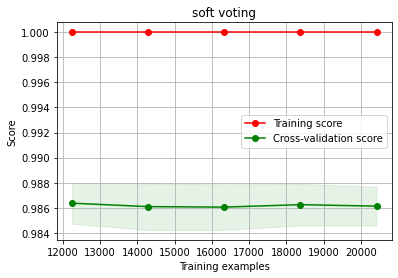

In [27]:
plot_learning(vote_best_test, "{}".format("soft voting"), X=Xtrain,y=ytrain,ylim=None)